<a href="https://colab.research.google.com/github/nedokormysh/OpenEdu_HSE_INTRML/blob/week3/Copy_of_LinearRegression_Screencast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [83]:
!pip install -q kaggle

In [84]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# from google.colab import files
# uploaded = files.upload()

In [86]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
 68% 58.0M/85.8M [00:00<00:00, 135MB/s] 
100% 85.8M/85.8M [00:00<00:00, 150MB/s]


In [87]:
# ! kaggle datasets list

In [88]:
import os
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [89]:
%ls

drive/        sample_submission.csv  test.csv  train.csv
sample_data/  sample_submission.zip  test.zip  train.zip


Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [90]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')
# df = pd.read_csv('train.csv')

In [91]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [92]:
df = df.drop('dropoff_datetime', axis=1)

Мы хотим разбить наши данные на train и test, но когда у ваших данных есть дата, у вас появляется временная размерность, и разбиение на train и test
уже может быть не таким очевидным как раньше просто с помощью функции train_test_split.
Почему? Потому что теперь нам было бы нечестно использовать данные для
обучения для того чтобы предсказывать какие-то зависимости в прошлом, потому
что на практике на самом деле мы хотим строить модели по прошлым данным и
работать с ними в будущем. Например, если бы я строил такую модель сегодня, я бы
взял все данные на сегодняшний день, обучил хорошую модель и начал бы ей
пользоваться завтра, соответственно, разбиение на train и test тоже должно использовать время, и мы должны взять для train данные, начиная с какой-то даты, и, например, до некоторой заранее обусловленной, и для теста у нас пойдут данные, то есть поездки, которые произошли после этой даты, давайте это сделаем. 

Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [93]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [94]:
df = df.sort_values(by='pickup_datetime')

In [95]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


Разбиваем данные по индексу. Отнесём первые миллион наблюдений в трейн.

In [96]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

In [97]:
len(df_train)

1000000

In [98]:
len(df_test)

458644

Этого вполне достаточно для подсчёта метрик.

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

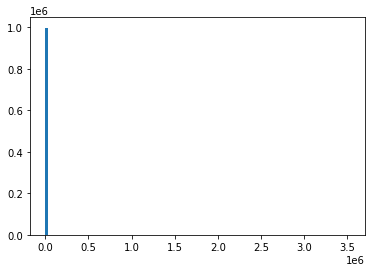

In [99]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

np.log1p.

Что это за функция? Эта функция логарифм 1 плюс x. Зачем не прибавлять еще единицу? Потому что вдруг у нас есть данные, которые содержат ноль, например, поездка завершилась сразу же, поэтому trip_duration будет равен нулю, какая-то ошибка, такое может произойти, и, чтобы не получить логарифм 0, я прибавлю единицу, и это стандартная функция в NumPy.

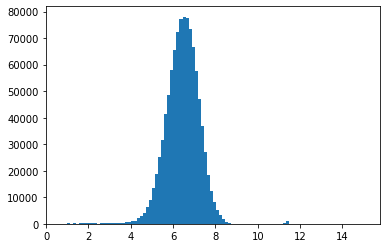

In [100]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. (иногда это помогает улучшить модель, если наш таргет распределён нормально). Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [101]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
# df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

In [103]:
df_train.pickup_datetime[0]

Timestamp('2016-03-14 17:24:55')

In [104]:
df_train.pickup_datetime[0].hour

17

Вытащим из нашего датасета только дату, а время не будем рассматривать. Эпплай применит некоторую функцию к каждому элементу нашего столбца.

In [105]:
date = df_train.pickup_datetime.apply(lambda x: x.date())
date

96469      2016-01-01
223872     2016-01-01
713067     2016-01-01
652463     2016-01-01
722901     2016-01-01
              ...    
1384418    2016-05-04
1100978    2016-05-04
630885     2016-05-04
567651     2016-05-04
777457     2016-05-04
Name: pickup_datetime, Length: 1000000, dtype: object

В переменной date лежат даты с первого января по 4 мая 2016. Теперь можем это визуализировать.

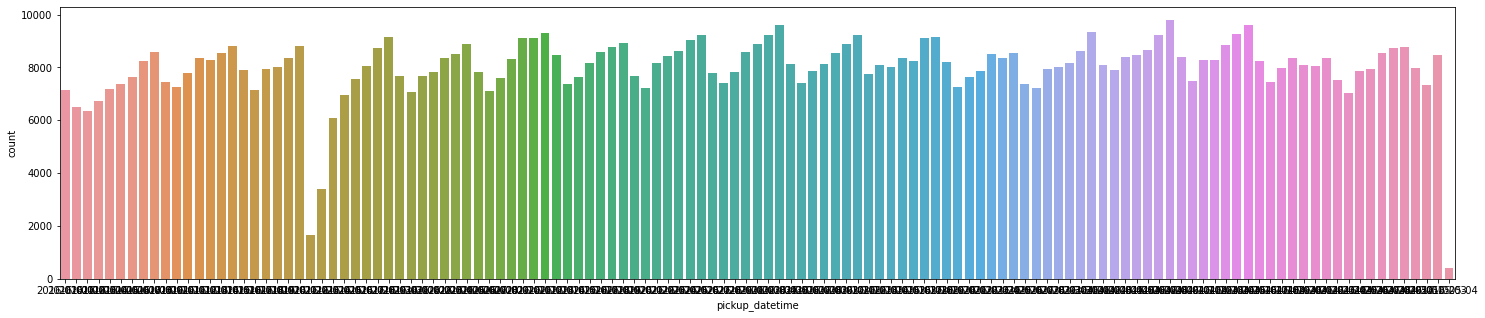

In [106]:
plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(x=date)

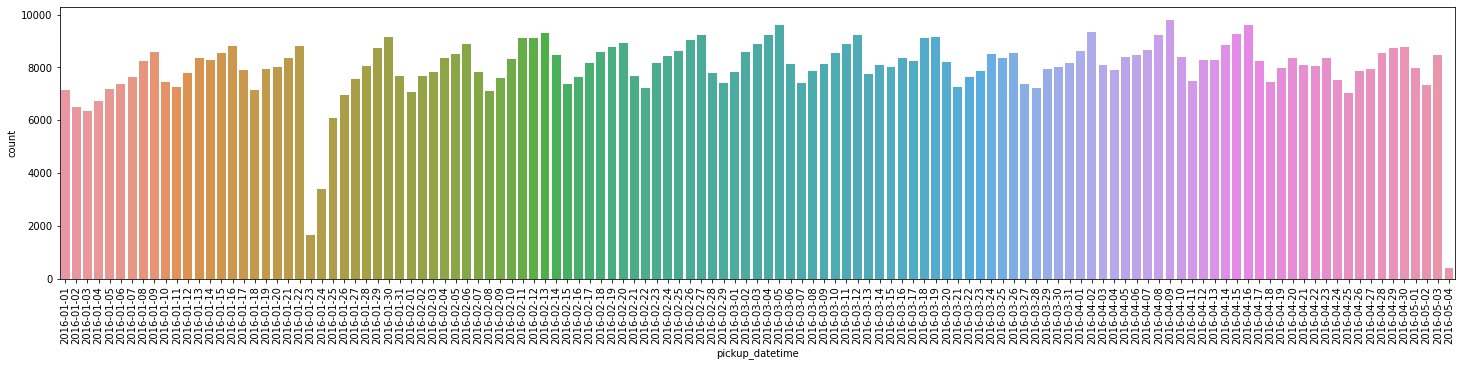

In [107]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы построили график, который соответствует количеству поездок по дням, но мы хотим убедиться, что те переменные, которые мы будем использовать для предсказания, они связаны со средней длиной поездки, например, мы могли бы в
качестве признака использовать день. Давайте убедимся, что, действительно, в
зависимости от дня у нас меняется длина поездки.

Мы можем воспользоваться pandas-овским groupby и сгруппировать наши данные по дате, которая у нас записано в переменную date. grouped_train мы назовем эту переменную, отлично.

In [108]:
grouped_train = df_train.groupby(by=date)

Визуализируем то, как связана средняя длина поездки по дням в зависимости от дня, для этого нам понадобится replpot, relative plot из пакета seaborn, дата у нас будет это наши сгруппированные данные grouped_train, мы хотим посмотреть как связан trip_duration и дата, поэтому берем trip_duration и можем у log_trip_duration из-за того, что это сгруппированные данные, позвать некоторый метод aggregate, которые внутри каждой группы посчитают что-либо, что мы попросим. В данном случае мне интересно средняя длина поездки по дням, поэтому я и говорю агрегируй мне, пожалуйста, мои данные по дням и агрегируй в виде среднего. 

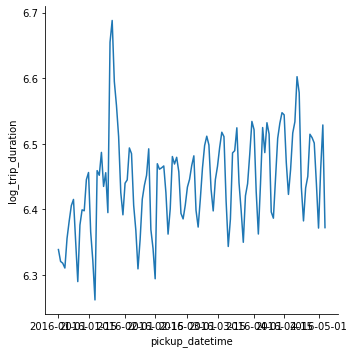

In [109]:
sns.relplot(data=grouped_train.log_trip_duration.agg('mean'), kind='line')

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


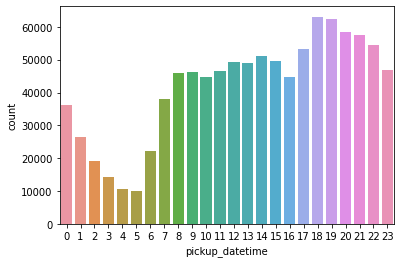

In [110]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

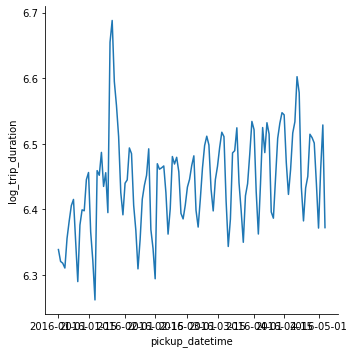

In [111]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. С ростом даты средняя длина поездки в логарифмах растёт. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [112]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )
  
  return X, data_frame.log_trip_duration

In [113]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [200]:
X_train

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0
...,...,...
1384418,125,3
1100978,125,3
630885,125,3
567651,125,3


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [115]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [116]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

спарс- фалс, чтобы нам вернулись нампай таблицы. а не специальные таблицы для хранения разреженных данных и из категориальных признаков только час. Т.е. категориальный признак находится под первым индексом.

In [117]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [118]:
X_train.shape

(1000000, 25)

In [119]:
X_train

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.]])

первый столбец превратился в 24 новых признака. Соответсвует часам от 0 до 23 Нулевой столбец поместился в конец.

Воспользуемся классом `Ridge` и обучим модель.

In [120]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

In [121]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [122]:
mean_squared_error(lin_reg.predict(X_test), y_test)

0.653821900058279

In [123]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [124]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760849

Давайте попробуем сделать лучше и подберем гиперпараметры модели.

У нас 500 тысяч измерений. И средняя ошибка будет иметь очень малую дисперсию. А потому можем смотреть даже 6 знак после запятой.

In [125]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 1000, 10)},
                             cv=5).fit(X_train, y_train)

In [126]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538801145824535

In [127]:
grid_searcher.best_params_

{'alpha': 400.0}

Регуляризация помогает не всегда. Очень небольшое количество признаков и большое количество наблюдений. Миллион. 
Регуляризация часто полезна именно в дргом направлении, когда признаков много, а наблюдений не очень.

# Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. Какой из этих графиков соответствует правильному?


[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6')]

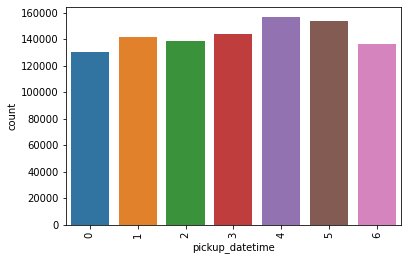

In [128]:
day_of_week_sorted = df_train.pickup_datetime.apply(lambda x: x.weekday()).sort_values()

# plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(x=day_of_week_sorted)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90)

# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features.

In [207]:
# df['log_trip_duration'] = np.log1p(df_train.trip_duration)
# df

In [206]:
# sns.displot(df['log_trip_duration'], bins=40, kde=True)

In [227]:
# plt.figure(figsize=(6, 4))

# sns.boxplot(df_train['log_trip_duration'], whis=1.5, orient='h')

In [169]:
# df.loc[df['log_trip_duration' < 2]
# df.loc[(df['log_trip_duration'].notna()) & (df['log_trip_duration'] < 0.7), ['pickup_datetime','log_trip_duration']]

In [230]:
# df_group_by_date = df.groupby(df['pickup_datetime']).agg({'id': 'count'})
# df_group_by_date

In [231]:
# df['pickup_datetime'].value_counts()

In [233]:
# date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).value_counts()
# date_sorted

In [203]:
import datetime
def create_features_2(data_frame):
  X = pd.concat([data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
                 data_frame.pickup_datetime.apply(lambda x: x.hour)], axis=1, keys=['day', 'hour'])
  X['log_trip_duration_ouliers'] = 0
  # print(type(X))
  X.loc[((X['day'] == 23)|(X['day'] == 125)),'log_trip_duration_ouliers'] = 1
  
  return X, data_frame.log_trip_duration

In [204]:
X_train_2, y_train_2 = create_features_2(df_train)
X_train_2

,day,hour,log_trip_duration_ouliers
96469,1,0,0
223872,1,0,0
713067,1,0,0
652463,1,0,0
722901,1,0,0
...,...,...,...
1384418,125,3,1
1100978,125,3,1
630885,125,3,1
567651,125,3,1


In [197]:
# import datetime
# from sklearn.preprocessing import scale

# blizzard = [datetime.date(2016, 1, 23), datetime.date(2016, 1, 24)]

# def create_features_3(sample: pd.DataFrame):
#     x = pd.DataFrame(
#         {
#             'day': scale(sample.pickup_datetime.dt.dayofyear),
#             'hour': sample.pickup_datetime.dt.hour,
#             'anom': np.where(sample.pickup_datetime.dt.date.isin(blizzard), 1, 0),
#             'dow': sample.pickup_datetime.dt.dayofweek
#         }
#     )
#     return x, sample.target_log

In [205]:
# X_train_3, y_train_3 = create_features_3(df_train)
# X_train_3

# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.

2. Заново проведите one-hot кодирование. Сколько признаков у вас получилось?

In [364]:
import datetime
def create_features_4(data_frame):
  X = pd.concat([data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
                 data_frame.pickup_datetime.apply(lambda x: x.hour),
                 data_frame.pickup_datetime.apply(lambda x: x.day_of_week)], 
                 axis=1, keys=[  'day', 'hour', 'day_of_week']
                 )
  X['log_trip_duration_ouliers'] = 0
  X.loc[((X['day'] == 23)|(X['day'] == 125)),'log_trip_duration_ouliers'] = 1
  
  return X, data_frame.log_trip_duration

In [365]:
X_train_4, y_train_4 = create_features_4(df_train)
X_train_4.tail()

,day,hour,day_of_week,log_trip_duration_ouliers
1384418,125,3,2,1
1100978,125,3,2,1
630885,125,3,2,1
567651,125,3,2,1
777457,125,3,2,1


In [355]:
# X_train_4['hour'].value_counts()

In [366]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1, 2])], remainder="passthrough")
X_train_4 = ohe.fit_transform(X_train_4)
X_train_4

array([[  1.,   0.,   0., ...,   0.,   1.,   0.],
       [  1.,   0.,   0., ...,   0.,   1.,   0.],
       [  1.,   0.,   0., ...,   0.,   1.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0., 125.,   1.],
       [  0.,   0.,   0., ...,   0., 125.,   1.],
       [  0.,   0.,   0., ...,   0., 125.,   1.]])

In [357]:
X_train_4[100000]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0., 14.,  0.])

In [358]:
len(X_train_4[0])

33

In [367]:
columns_to_return_names = ['hour0', 'hour1', 'hour2', 'hour3', 'hour4', 'hour5', 'hour6', 'hour7', 'hour8', 'hour9',
                          'hour10', 'hour11', 'hour12', 'hour13', 'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19',
                          'hour20', 'hour 21', 'hour22', 'hour23',
                          'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
                          'day', 'outliers']
len(columns_to_return_names)

33

In [340]:
# columns=[                                  
#                                           'hour0',  'hour1',  'hour2',  'hour3',  'hour4',  'hour5',  'hour6',  'hour7',  'hour8',  'hour9'
#                                           'hour10', 'hour11', 'hour12', 'hour13', 'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19',
#                                            'hour20', 'hour21', 'hour22', 'hour23',
#                                           'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
#                                           'day', 'outliers'
#                                           ]
# len(columns)

32

In [368]:
X_return=pd.DataFrame(X_train_4, columns=columns_to_return_names)
X_return.tail()

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day,outliers
999995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.0,1.0
999996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.0,1.0
999997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.0,1.0
999998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.0,1.0
999999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.0,1.0


# Вопрос 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).


In [350]:
# X_return['day']

In [369]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['day']

X_train_norm = X_return.copy()

X_train_norm['day'] = scaler.fit_transform(X_return[cols_to_scale])
X_train_norm

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day,outliers
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.776795,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.776795,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.776795,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.776795,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.776795,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.731355,1.0
999996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.731355,1.0
999997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.731355,1.0
999998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.731355,1.0


In [370]:
X_test_4, y_test_4 = create_features_4(df_test)
X_test_4.tail()

,day,hour,day_of_week,log_trip_duration_ouliers
853710,182,23,3,0
419031,182,23,3,0
1008720,182,23,3,0
405743,182,23,3,0
500524,182,23,3,0


In [371]:
X_test_4 = ohe.transform(X_test_4)
X_test_4

array([[  0.,   0.,   0., ...,   0., 125.,   1.],
       [  0.,   0.,   0., ...,   0., 125.,   1.],
       [  0.,   0.,   0., ...,   0., 125.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0., 182.,   0.],
       [  0.,   0.,   0., ...,   0., 182.,   0.],
       [  0.,   0.,   0., ...,   0., 182.,   0.]])

In [372]:
X_return_test=pd.DataFrame(X_test_4, columns=columns_to_return_names)
X_return_test.tail()

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day,outliers
458639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,182.0,0.0
458640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,182.0,0.0
458641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,182.0,0.0
458642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,182.0,0.0
458643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,182.0,0.0


In [373]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['day']

X_test_norm = X_return_test.copy()

X_test_norm['day'] = scaler.fit_transform(X_return_test[cols_to_scale])
X_test_norm

,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,...,hour23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day,outliers
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.660651,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.660651,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.660651,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.660651,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.660651,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.725090,0.0
458640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.725090,0.0
458641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.725090,0.0
458642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.725090,0.0


In [375]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
X_train_norm.head(5)

In [ ]:
y_train

In [389]:
lasso_model = Lasso(alpha=2.65e-05, 
                    # tol=0.000001
                    ).fit(X_train_norm, y_train)

In [395]:
mean_squared_error(lasso_model.predict(X_test_norm), y_test)

0.655756315223368

In [383]:
lasso_model.feature_names_in_

array(['hour0', 'hour1', 'hour2', 'hour3', 'hour4', 'hour5', 'hour6',
       'hour7', 'hour8', 'hour9', 'hour10', 'hour11', 'hour12', 'hour13',
       'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19',
       'hour20', 'hour 21', 'hour22', 'hour23', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day', 'outliers'], dtype=object)

In [384]:
len(lasso_model.feature_names_in_)

33

In [390]:
lasso_model.coef_

array([-2.31033262e-02, -5.38055623e-02, -8.91769982e-02, -8.96338764e-02,
       -9.10935111e-02, -2.02358147e-01, -2.73634977e-01, -1.19863281e-01,
       -8.52069310e-03,  1.19226798e-02,  1.81432390e-02,  4.88459371e-02,
        5.20158474e-02,  6.75613923e-02,  9.14021273e-02,  9.79395903e-02,
        7.02324914e-02,  6.53457585e-02,  3.74357742e-02, -2.01893284e-02,
       -3.58941404e-02, -2.93384135e-02,  1.24496443e-07,  1.00444524e-03,
       -6.34803995e-02,  0.00000000e+00,  8.94766156e-03,  3.05401021e-02,
        1.02962361e-02, -7.07778532e-02, -1.13153690e-01,  2.81506264e-02,
        7.68157899e-02])

In [391]:
len(lasso_model.coef_)

33

In [394]:
i = 0
for c in lasso_model.coef_:
  if np.abs(c) > 0.000001:
    i += 1

print(i)

31
